## This is the softmax workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

The goal of this workbook is to give you experience with training a softmax classifier.

In [96]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '/Users/saeedfiroozi/Downloads/cifar-10-batches-py' # You need to update this line
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [98]:
from nndl import Softmax

In [99]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [149]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [150]:
print(loss)

2.273129256583173


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this make sense?

## Answer:

This makes sense because we havent trained the model so it has a very high loss.

#### Softmax gradient

In [173]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

(10, 500)

(500, 3073)

numerical: 0.000000 analytic: -0.000275, relative error: 1.000000e+00
numerical: 0.000000 analytic: 0.000054, relative error: 1.000000e+00
numerical: 0.000000 analytic: -0.000236, relative error: 1.000000e+00
numerical: 0.000000 analytic: -0.000028, relative error: 1.000000e+00
numerical: 0.000000 analytic: -0.000160, relative error: 1.000000e+00
numerical: 0.000000 analytic: -0.000083, relative error: 1.000000e+00
numerical: 0.000000 analytic: 0.000333, relative error: 1.000000e+00
numerical: 0.000000 analytic: -0.000210, relative error: 1.000000e+00
numerical: -1.524870 analytic: -0.000216, relative error: 9.997171e-01
numerical: 0.000000 analytic: 0.000072, relative error: 1.000000e+00


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [26]:
import time

In [63]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 2.54 / 213627973.7561642 computed in 0.10389590263366699s


(500, 3073)

(500,)

(10, 3073)

Vectorized loss / grad: 2.54 / 213627973.7561642 computed in 0.09031915664672852s
difference in loss / grad: 0.0 /0.0 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

iteration 0 / 1500: loss 2.26
iteration 100 / 1500: loss 1.335


/Users/saeedfiroozi/Downloads/hw2_Questions/code/nndl/softmax.py:118: RuntimeWarning: overflow encountered in exp
  
/Users/saeedfiroozi/Downloads/hw2_Questions/code/nndl/softmax.py:119: RuntimeWarning: invalid value encountered in true_divide
  return loss, grad


iteration 200 / 1500: loss 1.335
iteration 300 / 1500: loss 1.335
iteration 400 / 1500: loss 1.335
iteration 500 / 1500: loss 1.335
iteration 600 / 1500: loss 1.335
iteration 700 / 1500: loss 1.335
iteration 800 / 1500: loss 1.335
iteration 900 / 1500: loss 1.335
iteration 1000 / 1500: loss 1.335
iteration 1100 / 1500: loss 1.335
iteration 1200 / 1500: loss 1.335
iteration 1300 / 1500: loss 1.335
iteration 1400 / 1500: loss 1.335
That took 1.5340638160705566s


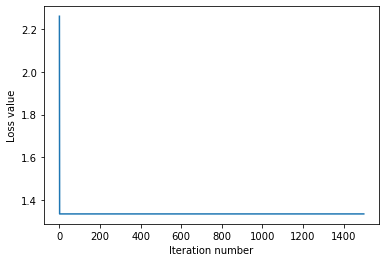

In [81]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [95]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

(49000, 3073)

(10, 3073)

training accuracy: 0.0


(1000, 3073)

(10, 3073)

validation accuracy: 0.0


## Optimize the softmax classifier

In [ ]:
np.finfo(float).eps

iteration 0 / 1500: loss 2.15
iteration 100 / 1500: loss 2.335


/Users/saeedfiroozi/Downloads/hw2_Questions/code/nndl/softmax.py:136: RuntimeWarning: overflow encountered in exp
  - X: A numpy array of shape (N, D) containing training data; there are N
/Users/saeedfiroozi/Downloads/hw2_Questions/code/nndl/softmax.py:137: RuntimeWarning: invalid value encountered in true_divide
  training samples each of dimension D.


iteration 200 / 1500: loss 2.335
iteration 300 / 1500: loss 2.335
iteration 400 / 1500: loss 2.335
iteration 500 / 1500: loss 2.335
iteration 600 / 1500: loss 2.335
iteration 700 / 1500: loss 2.335
iteration 800 / 1500: loss 2.335
iteration 900 / 1500: loss 2.335
iteration 1000 / 1500: loss 2.335
iteration 1100 / 1500: loss 2.335
iteration 1200 / 1500: loss 2.335
iteration 1300 / 1500: loss 2.335
iteration 1400 / 1500: loss 2.335


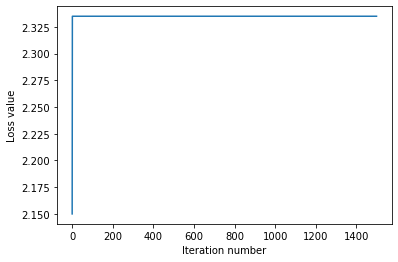

iteration 0 / 1500: loss 3.615
iteration 100 / 1500: loss 3.835
iteration 200 / 1500: loss 3.835
iteration 300 / 1500: loss 3.835
iteration 400 / 1500: loss 3.835
iteration 500 / 1500: loss 3.835
iteration 600 / 1500: loss 3.835
iteration 700 / 1500: loss 3.835
iteration 800 / 1500: loss 3.835
iteration 900 / 1500: loss 3.835
iteration 1000 / 1500: loss 3.835
iteration 1100 / 1500: loss 3.835
iteration 1200 / 1500: loss 3.835
iteration 1300 / 1500: loss 3.835
iteration 1400 / 1500: loss 3.835


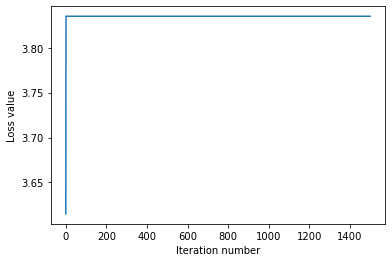

iteration 0 / 1500: loss 2.5725
iteration 100 / 1500: loss 4.335
iteration 200 / 1500: loss 4.335
iteration 300 / 1500: loss 4.335
iteration 400 / 1500: loss 4.335
iteration 500 / 1500: loss 4.335
iteration 600 / 1500: loss 4.335
iteration 700 / 1500: loss 4.335
iteration 800 / 1500: loss 4.335
iteration 900 / 1500: loss 4.335
iteration 1000 / 1500: loss 4.335
iteration 1100 / 1500: loss 4.335
iteration 1200 / 1500: loss 4.335
iteration 1300 / 1500: loss 4.335
iteration 1400 / 1500: loss 4.335


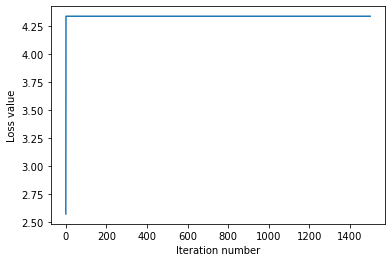

iteration 0 / 1500: loss 4.2625
iteration 100 / 1500: loss 2.835
iteration 200 / 1500: loss 2.835
iteration 300 / 1500: loss 2.835
iteration 400 / 1500: loss 2.835
iteration 500 / 1500: loss 2.835
iteration 600 / 1500: loss 2.835
iteration 700 / 1500: loss 2.835
iteration 800 / 1500: loss 2.835
iteration 900 / 1500: loss 2.835
iteration 1000 / 1500: loss 2.835
iteration 1100 / 1500: loss 2.835
iteration 1200 / 1500: loss 2.835
iteration 1300 / 1500: loss 2.835
iteration 1400 / 1500: loss 2.835


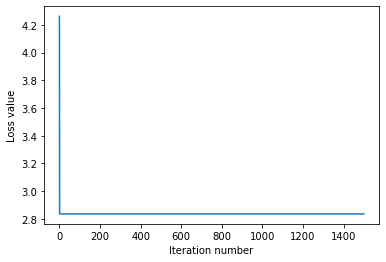

In [175]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #

for i in list([0.05, 0.1,0.2,0.3]):
    loss_hist = softmax.train(X_train, y_train, learning_rate=i,
                      num_iters=1500, verbose=True)
    plt.plot(loss_hist)
    plt.xlabel('Iteration number')
    plt.ylabel('Loss value')
    plt.show()

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


In [ ]:
It looks like learning rate 0.05 did the best with an error of 2.3